C:\Users\local_fei.li\Temp\ipykernel_4416\3863945812.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)
C:\Users\local_fei.li\Temp\ipykernel_4416\3863945812.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette='coolwarm')


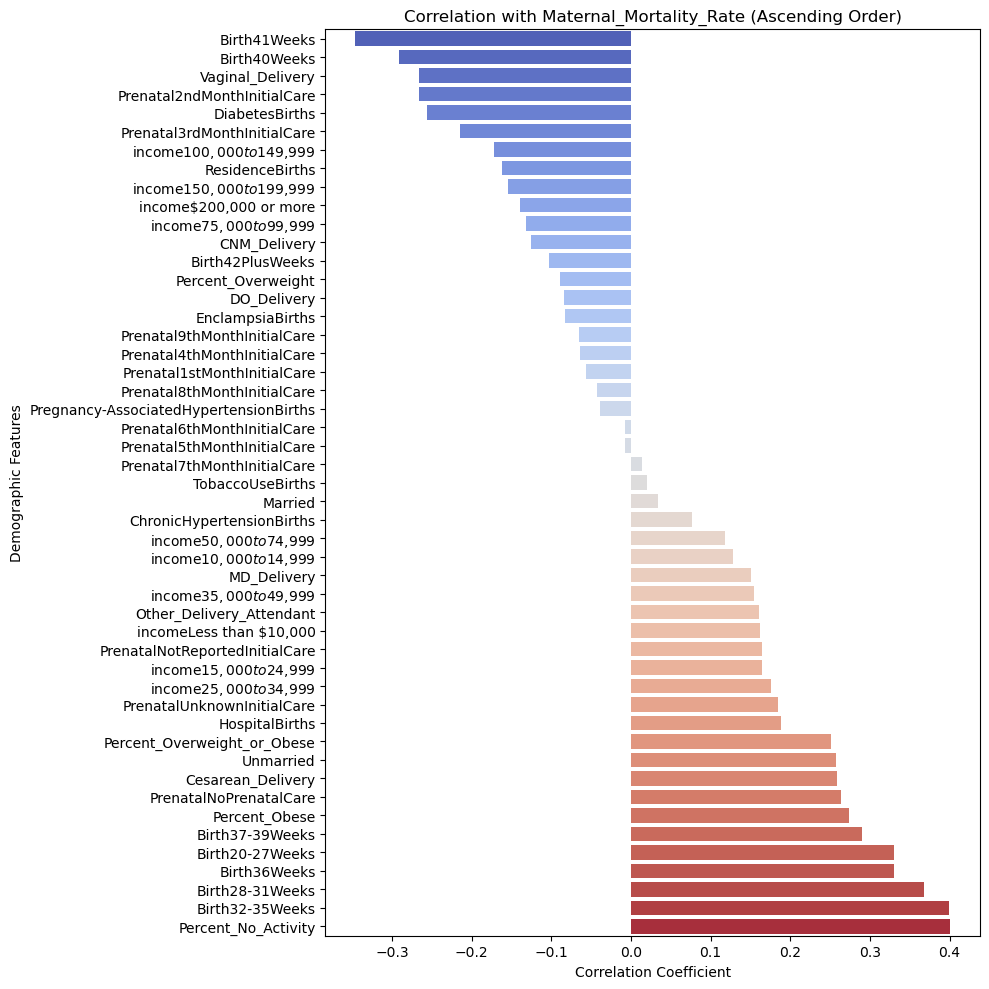

Cross-validated RMSE score: 104.00
Cross-validated R^2 score: 0.21
Test Set Mean Squared Error: 87.61
Test Set Root Mean Squared Error: 9.36
Test Set R^2: 0.52
Feature Importances:
PrenatalUnknownInitialCare                0.275123
Birth28-31Weeks                           0.057761
PrenatalNoPrenatalCare                    0.056728
Other_Delivery_Attendant                  0.056203
income$50,000 to $74,999                  0.054894
Percent_No_Activity                       0.054773
HospitalBirths                            0.048165
Birth36Weeks                              0.033710
CNM_Delivery                              0.031331
Birth41Weeks                              0.023358
Cesarean_Delivery                         0.022345
Prenatal3rdMonthInitialCare               0.019818
DO_Delivery                               0.019311
ResidenceBirths                           0.017607
income$25,000 to $34,999                  0.017374
Birth40Weeks                              0.016808
Bir

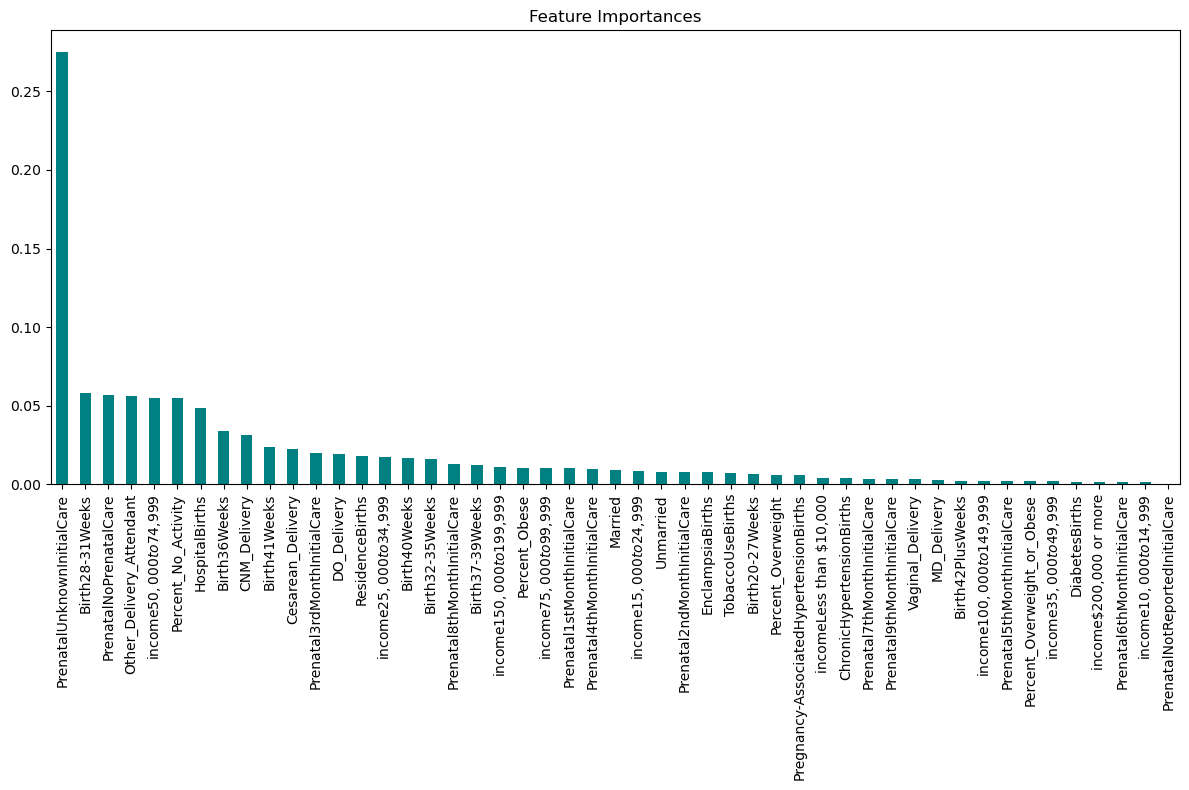

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the Data
data = pd.read_excel("R:/Fei.Li/Python/Erdos/merged_data_scaled_totals.xlsx")

data.sample(5)

# Step 2: Data Preprocessing
# Assuming 'Maternal_Mortality_Rate' is the target variable
target = 'Maternal_Mortality_Rate'
features = data.columns.drop(['State', 'Year', 'Births', target])

X = data[features]
y = data[target]

# Handle missing values if necessary
X.fillna(X.mean(), inplace=True)

# Step 3: Split the Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Exam Correlations
# Compute the correlation matrix
correlation_matrix = X_train.copy()
correlation_matrix[target] = y_train
correlation_matrix = correlation_matrix.corr()

# Extract the correlations with the target variable
target_correlation = correlation_matrix[target].drop(target)

# Plot the correlations
plt.figure(figsize=(10, 10))
sorted_correlations = target_correlation.sort_values()  # Sort the target correlations in ascending order
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette='coolwarm')

plt.title('Correlation with ' + target + ' (Ascending Order)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Demographic Features')

plt.tight_layout()
plt.show()

# Step 5: Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Step 6: Cross-validation
# Perform 5-fold cross-validation
cv_classes = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=168)
gradient_boost = Pipeline([("scale", StandardScaler()), ("boost", GradientBoostingRegressor(loss='squared_error', learning_rate=0.01, random_state=25))])

# Cross-validation for RMSE
gb_cross_val_score = cross_val_score(estimator=gradient_boost, cv=rkf, scoring='neg_mean_squared_error', X=X_train, y=y_train)
print(f"Cross-validated RMSE score: {np.mean(-gb_cross_val_score):.2f}")

# Cross-validation for R^2
gb_r2_cross_val_score = cross_val_score(estimator=gradient_boost, cv=rkf, scoring='r2', X=X_train, y=y_train)
print(f"Cross-validated R^2 score: {np.mean(gb_r2_cross_val_score):.2f}")

# Step 7: Train the model on the full training set
gbr.fit(X_train, y_train)

# Step 8: Evaluate the model's performance on the test set
y_pred = gbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Test Set Mean Squared Error: {mse:.2f}")
print(f"Test Set Root Mean Squared Error: {rmse:.2f}")
print(f"Test Set R^2: {r2:.2f}")

# Step 9: Feature importances
feature_importances = pd.Series(gbr.feature_importances_, index=features)
print("Feature Importances:")
print(feature_importances.sort_values(ascending=False))

# Plot the feature importances
plt.figure(figsize=(12, 8))
feature_importances.sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()